In [58]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
def load_data(file_path):
    sentences = []
    labels = []
    sentence = []
    label = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split()
                if len(parts) == 2:
                    word, tag = parts
                    sentence.append(word)
                    label.append(tag)
                else:
                    # Mengabaikan baris yang tidak memiliki tepat dua elemen
                    continue
            else:
                if sentence and label:
                    sentences.append(sentence)
                    labels.append(label)
                sentence = []
                label = []

    # Untuk menangani kalimat terakhir jika tidak diakhiri oleh baris kosong
    if sentence and label:
        sentences.append(sentence)
        labels.append(label)

    return sentences, labels



train_sentences, train_labels = load_data('./dataset/train_preprocess.txt')
val_sentences, val_labels = load_data('./dataset/valid_preprocess.txt')
test_sentences, test_labels = load_data('./dataset/test_preprocess.txt')



Train class distribution: {'O': 132986, 'B-PLC': 4365, 'B-PPL': 4844, 'I-PPL': 2818, 'B-EVT': 1022, 'I-PLC': 2003, 'B-IND': 3065, 'I-IND': 2202, 'I-EVT': 1619, 'B-FNB': 509, 'I-FNB': 308}
Validation class distribution: {'O': 16696, 'B-PLC': 517, 'B-PPL': 640, 'I-PPL': 386, 'B-IND': 369, 'B-EVT': 127, 'B-FNB': 87, 'I-FNB': 47, 'I-EVT': 174, 'I-PLC': 225, 'I-IND': 286}


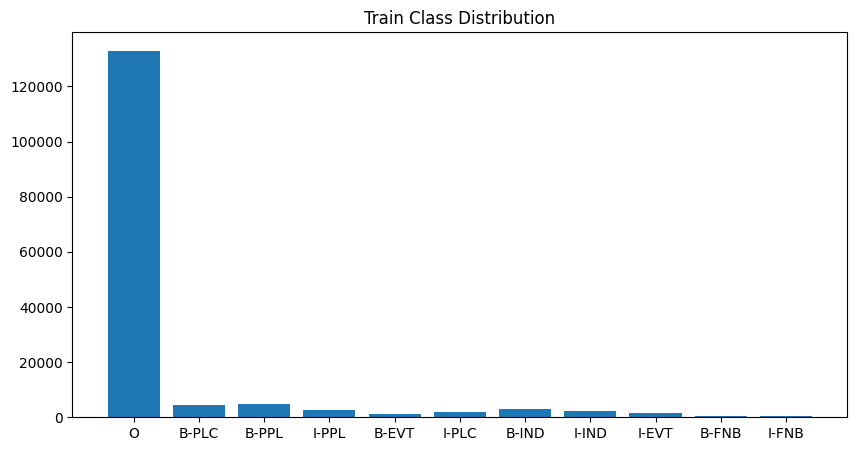

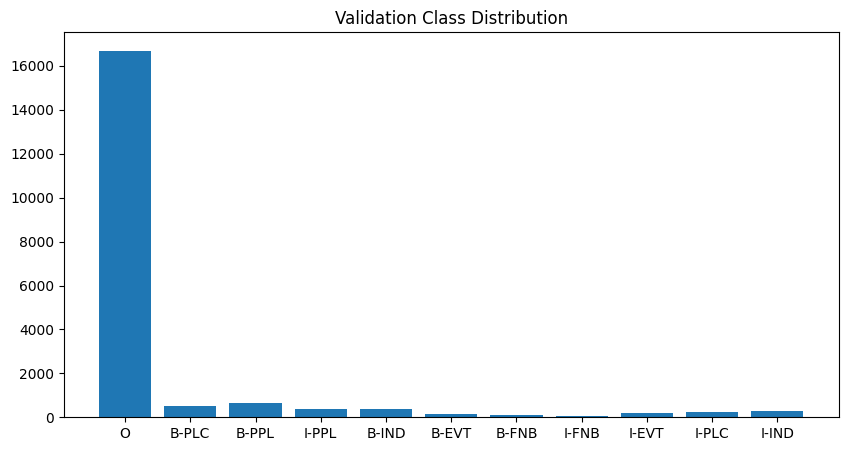

In [60]:
# class distribution

def class_distribution(labels):
    class_distribution = {}
    for sentence in labels:
        for tag in sentence:
            if tag in class_distribution:
                class_distribution[tag] += 1
            else:
                class_distribution[tag] = 1
    return class_distribution

train_class_distribution = class_distribution(train_labels)
val_class_distribution = class_distribution(val_labels)

print('Train class distribution:', train_class_distribution)
print('Validation class distribution:', val_class_distribution)

# plot class distribution
import matplotlib.pyplot as plt

def plot_class_distribution(class_distribution, title):
    plt.figure(figsize=(10, 5))
    plt.bar(class_distribution.keys(), class_distribution.values())
    plt.title(title)
    plt.show()

plot_class_distribution(train_class_distribution, 'Train Class Distribution')

plot_class_distribution(val_class_distribution, 'Validation Class Distribution')



In [ ]:

# Tokenisasi kata dan label
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences + val_sentences + test_sentences)
word_index = tokenizer.word_index

max_len = max(len(sentence) for sentence in train_sentences + val_sentences + test_sentences)
num_words = len(word_index) + 1

X_train = pad_sequences(tokenizer.texts_to_sequences(train_sentences), maxlen=max_len, padding='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(val_sentences), maxlen=max_len, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test_sentences), maxlen=max_len, padding='post')

# Membuat indeks label
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels + val_labels + test_labels)
label_index = label_tokenizer.word_index
num_labels = len(label_index) + 1

y_train = pad_sequences(label_tokenizer.texts_to_sequences(train_labels), maxlen=max_len, padding='post')
y_val = pad_sequences(label_tokenizer.texts_to_sequences(val_labels), maxlen=max_len, padding='post')
y_test = pad_sequences(label_tokenizer.texts_to_sequences(test_labels), maxlen=max_len, padding='post')

y_train = to_categorical(y_train, num_labels)
y_val = to_categorical(y_val, num_labels)
y_test = to_categorical(y_test, num_labels)

In [7]:
X_train.shape

(6720, 110)

In [11]:
from gensim.models import Word2Vec

# Melatih Word2Vec pada korpus teks
all_sentences = train_sentences + val_sentences + test_sentences
word2vec_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Membuat matriks embedding
embedding_dim = 100
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [23]:



model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 100,  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_len,), trainable=False),
    tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling1D(pool_size=2),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_labels, activation='softmax'))
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 110, 100)          │  2,128,500 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_6 (Conv1D)               │ (None, 110, 128)          │     38,528 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_6 (LSTM)                   │ (None, 110, 64)           │     49,408 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_6              │ (None, 110, 16)           │      1,040 │
│ (TimeDistributed)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_7              │ (None, 110, 16)           │          0 │
│ (TimeDistributed)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ time_distributed_8              │ (None, 110, 12)           │        204 │
│ (TimeDistributed)               │                           │            │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,217,680 (8.46 MB)

 Trainable params: 2,217,680 (8.46 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 62s 168ms/step - accuracy: 0.7199 - loss: 1.0574 - val_accuracy: 0.9691 - val_loss: 0.1133
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 30s 143ms/step - accuracy: 0.9640 - loss: 0.3618 - val_accuracy: 0.9738 - val_loss: 0.0890
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - accuracy: 0.9680 - loss: 0.3087 - val_accuracy: 0.9779 - val_loss: 0.0814
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 30s 145ms/step - accuracy: 0.9713 - loss: 0.2721 - val_accuracy: 0.9802 - val_loss: 0.0716
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 31s 146ms/step - accuracy: 0.9735 - loss: 0.2419 - val_accuracy: 0.9801 - val_loss: 0.0701
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 31s 148ms/step - accuracy: 0.9746 - loss: 0.2189 - val_accuracy: 0.9806 - val_loss: 0.0719
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 32s 150ms/step - accuracy: 0.9756 - loss: 0.1945 - val_accuracy: 0.9815 - val_loss: 0.0773
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 31s 149ms/step - accuracy: 0.9788 - loss: 0

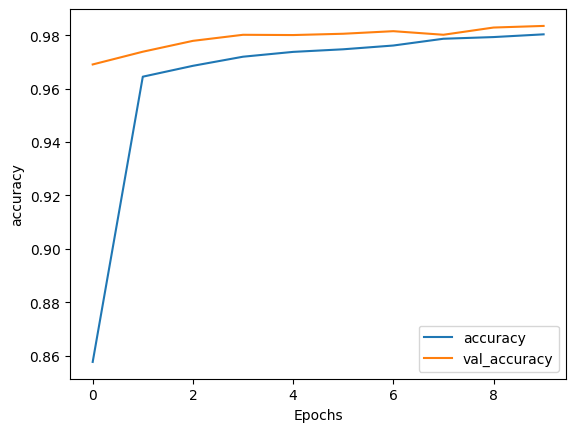

In [26]:
import matplotlib.pyplot as plt

# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

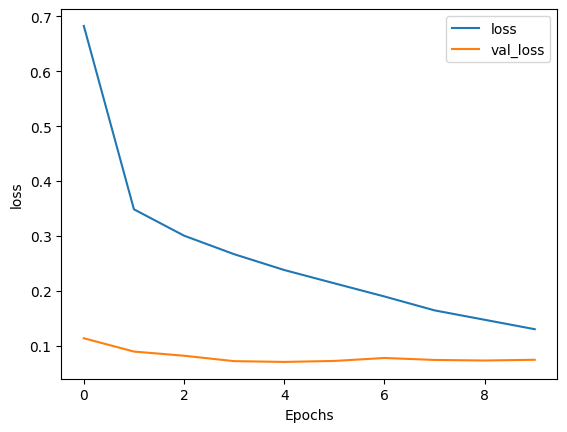

In [27]:
# losss
plot_graphs(history, "loss")

In [31]:
import numpy as np
from sklearn.metrics import classification_report

# Melakukan prediksi pada data validasi
y_pred = model.predict(X_val)

# Mendapatkan indeks label dengan nilai tertinggi
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true_classes = np.argmax(y_val, axis=-1)

# Mengubah prediksi dan label sebenarnya ke dalam format yang cocok untuk classification_report
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

# Menghapus padding dari prediksi dan label sebenarnya
mask = np.where(y_true_flat != 0)  # Mengasumsikan label '0' adalah padding
y_pred_flat = y_pred_flat[mask]
y_true_flat = y_true_flat[mask]

# Menampilkan laporan klasifikasi
report = classification_report(y_true_flat, y_pred_flat)
print(report)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.94      0.99      0.97     16696
           2       0.85      0.77      0.80       640
           3       0.71      0.73      0.72       517
           4       0.65      0.43      0.52       369
           5       0.90      0.62      0.74       386
           6       0.63      0.47      0.54       286
           7       0.59      0.47      0.52       225
           8       0.00      0.00      0.00       174
           9       0.00      0.00      0.00       127
          10       0.00      0.00      0.00        87
          11       0.00      0.00      0.00        47

    accuracy                           0.92     19554
   macro avg       0.44      0.37      0.40     19554
weighted avg       0.90      0.92      0.91     19554



c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [40]:
print(train_sentences)
print(len(train_labels[0]))


[['kepala', 'dinas', 'tata', 'kota', 'manado', 'amos', 'kenda', 'menyatakan', 'tidak', 'tahu', '-', 'menahu', 'soal', 'pencabutan', 'baliho', '.', 'ia', 'enggan', 'berkomentar', 'banyak', 'karena', 'merasa', 'bukan', 'kewenangannya', '.'], ['di', 'antara', 'mereka', 'itu', 'mengaku', 'tidak', 'tersinggung', 'dengan', 'ucapan', 'ahok', '...'], ['pasukan', 'pengibar', 'bendera', 'membawa', 'kereta', 'kencana', 'usai', 'latihan', 'upacara', 'pengibaran', 'bendera', 'jelang', 'perayaan', 'hut', 'kemerdekaan', 'ri', 'di', 'monas', ',', 'gambr', ',', 'jakarta', 'pusat', ',', 'minggu', '(', '13', '/', '8', ')', '.'], ['ketika', 'ditanyai', 'mengenai', 'kemungkinan', 'organisasi', 's.', 'h.', 'i.', 'e.', 'l.', 'd', 'menyadari', 'kehadiran', 'para', 'vigilante', '(', 'penegak', 'hukum', 'non-resmi', ')', 'dari', 'hells', 'kitchen', '--', 'sebuah', 'tempat', 'betulan', 'di', 'kota', 'new', 'york', 'yang', 'menjadi', 'set', 'lokasi', 'serial', 'daredevil', ',', 'jessica', 'jones', ',', 'the', 'pu

In [47]:
# Mengambil label unik dari train_labels
unique_labels = set(label for sublist in train_labels for label in sublist)

# Menampilkan label-label unik
print("Label Unik:")
print(unique_labels)

# Menghitung jumlah label unik
num_labels = len(unique_labels)
print("Jumlah Label Unik:", num_labels)

# Mengambil label unik dari train_labels
unique_labels = set(label for sublist in val_labels for label in sublist)

# Menampilkan label-label unik
print("Label Unik:")
print(unique_labels)

# Menghitung jumlah label unik
num_labels = len(unique_labels)
print("Jumlah Label Unik:", num_labels)


Label Unik:
{'I-IND', 'I-PPL', 'B-IND', 'B-PLC', 'I-FNB', 'B-PPL', 'I-EVT', 'O', 'B-FNB', 'B-EVT', 'I-PLC'}
Jumlah Label Unik: 11
Label Unik:
{'I-IND', 'I-PPL', 'B-IND', 'B-PLC', 'I-FNB', 'B-PPL', 'I-EVT', 'O', 'B-EVT', 'I-PLC', 'B-FNB'}
Jumlah Label Unik: 11


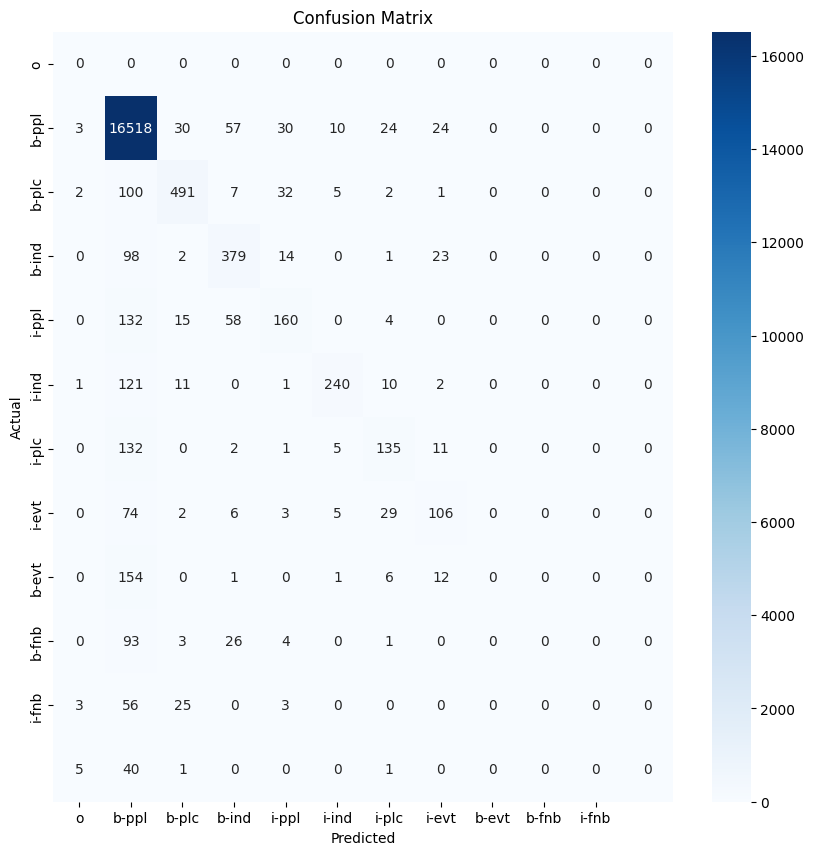

In [49]:
# confussion matrix with sns
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Menghitung matriks kebingungan
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Membuat plot matriks kebingungan
plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_index.keys(), yticklabels=label_index.keys(), cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

In [57]:
# Kalimat baru untuk pengujian
new_sentence = "Jokowi adalah presiden Indonesia yang ke-7"

# Tokenisasi teks

# Define the index_to_label dictionary
index_to_label = {v: k for k, v in label_index.items()}

sample_seq = tokenizer.texts_to_sequences([new_sentence])
sample_padded = pad_sequences(sample_seq, maxlen=max_len, truncating="post", padding="post")

# Lakukan prediksi dengan model
y_pred = model.predict(sample_padded)

# Mendapatkan indeks label dengan nilai tertinggi untuk setiap token
predicted_labels = [np.argmax(pred) for pred in y_pred[0]]

# Mengonversi indeks label menjadi label teks menggunakan inverse mapping
predicted_labels = [index_to_label.get(idx, 'O') for idx in predicted_labels]

# Menampilkan hasil prediksi
print("Kalimat:", new_sentence)
print("Prediksi NER:", predicted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Kalimat: Jokowi adalah presiden Indonesia yang ke-7
Prediksi NER: ['b-ppl', 'o', 'o', 'b-plc', 'o', 'o', 'o', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
